# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators
import alpaca_trade_api as trade_api
import os
import pandas as pd


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2020-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Bollinger Band configuration
bollinger_band_window = 20
num_standard_deviation = 2

# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv, 'close', bollinger_band_window, num_standard_deviation)


<AxesSubplot:title={'center':'TWOU Bollinger Bands'}, xlabel='Date', ylabel='Price (USD)'>

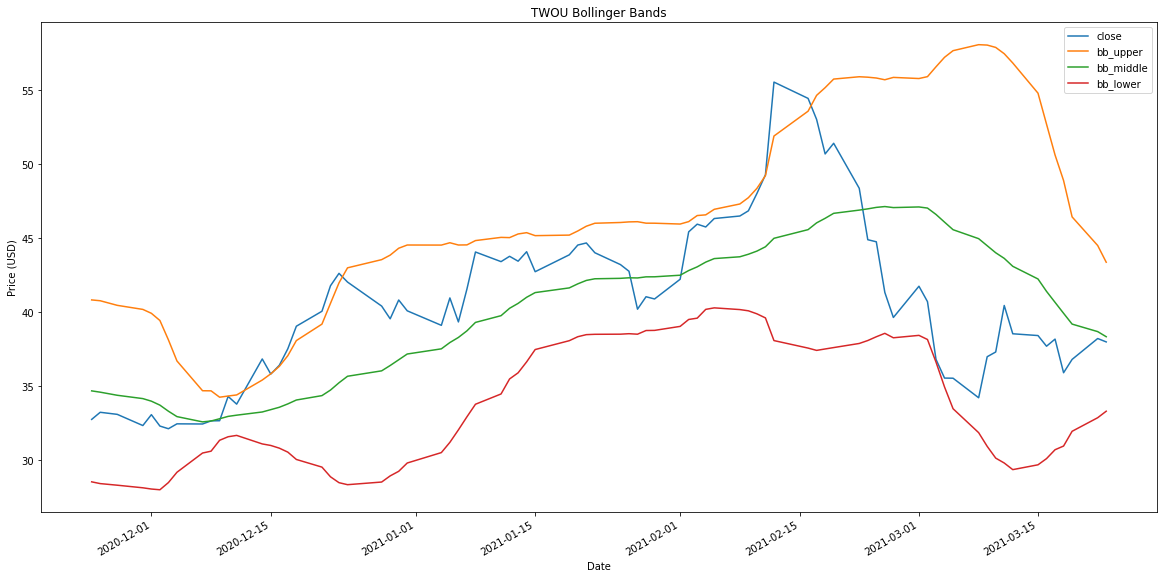

In [8]:
df_updated[['close', 'bb_upper', 'bb_middle', 'bb_lower']].plot(figsize=(20,10), title=f'{ticker} Bollinger Bands', xlabel='Date', ylabel='Price (USD)')


## Keltner Channels


In [9]:
# Generate average true range values
test1 = indicators.average_true_range_generator(df_updated)
df = indicators.keltner_channel_generator(test1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
